# **ESPIDAM: SIR Age-Structured Example**

***Authors: Sebastiaan Weytjens, Bram Silue, Pieter Libin, Niel Hens***

### **How to Run**
If you're having trouble running this code on your local machine, please open and run this notebook in Colab:

[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/plibin/espidam-25/blob/main/sir/3_sir_age_solution.ipynb)

We define some helper code that allows this notebook to run in both local environments and Google Colab:

In [1]:
import os
import urllib.request

def is_running_in_colab() -> bool:
    """
    Returns if the code is running inside Google Colab.

    """
    try:
        import google.colab
        return True
    except ImportError:
        return False

def download_file(filepath: str, 
                  url: str) -> None:
    """
    Download a file from a URL if it does not exist locally. This is only 
    performed when running inside Google Colab.

    Arguments
    ---------
    filepath :  The local path (including subdirectories) where the file should be saved.
    url      :  The direct URL to download the file from.

    """
    if is_running_in_colab() and not os.path.exists(filepath):
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        print(f"Downloading {filepath} from {url}")
        urllib.request.urlretrieve(url, filepath)

For Colab runs, we download the necessary files (i.e., helper functions, images, etc.):

In [2]:
if is_running_in_colab():
    download_file(filepath='img/age_sir_model.png', url=f'https://raw.githubusercontent.com/plibin/espidam-25/main/sir/img/age_sir_model.png')
    download_file(filepath='utils/sir_helpers.py', url=f'https://raw.githubusercontent.com/plibin/espidam-25/main/sir/utils/sir_helpers.py')

### **Age-Structured SIR: Adding Contact Behaviour**
Assume the following contact matrix, which contains contact between children and adults:

<img src="img/age_sir_model.png" alt="The diagram of an age-structured SIR model." style="width:400px;"/>

Rows and columns 0 and 1 represent children and adults, respectively. For example, $C_{0 1}$ are the contacts of children with adults, which is 9 in this case [1]. 



$C=\left(\begin{array}{cc}18 & 9 \\ 3 & 12\end{array}\right)$

Consequently, we modify the rate (i.e., the force of infection) between $S$ and $I$ as follows:

$
-\beta \cdot \sum_j C_{i j} \cdot I_j / N_j
$

The ODE equations for the age structured SIR model become the following: 

$
\begin{aligned}
\frac{{dS_i}}{{dt}} &= -\beta \cdot S_i \cdot \sum_j C_{i j} \cdot I_j / N_j \\
\frac{{dI_i}}{{dt}} &= \beta \cdot S_i \cdot \sum_j C_{i j} \cdot I_j / N_j - \gamma \cdot I_i\\
\frac{{dR_i}}{{dt}} &= \gamma \cdot I_i
\end{aligned}
$

[1]: SIR infectious disease model with age classes: https://sherrytowers.com/2012/12/11/sir-model-with-age-classes/

### **Dependencies**
First, make sure to install miniconda and the necessary libraries as specified in [`README.md`](README.md). After that, we import the necessary libraries and dependencies as follows:

In [3]:
import numpy as np
from numpy.linalg import eig
from scipy.integrate import odeint
from utils.sir_helpers import *

# Ignore warnings.
import warnings
warnings.filterwarnings("ignore")

### **Model Description**
We will start with the model description. We gave you head start by filling in the compartments, the contact matrix and the initial compartment values. Complete the force of infection and the rate between $I$ and $R$.

In [4]:
# Compartments.
compartments = {
    "S_c": [],
    "I_c": [],
    "R_c": [],
    "S_a": [],
    "I_a": [],
    "R_a": [],
}


# Contact matrix.
def contacts(i: int, j: int) -> int:
    """
    Returns the average number of contacts between two age groups.

    Arguments
    ---------
    i :  The index of the receiving age group.
    j :  The index of the contacting age group.

    Returns
    -------
    The average number of contacts from group j to group i.
    
    """
    # Note: This is not the most efficient way to return a matrix, but we prioritize clarity.
    contact_matrix = [
        [18, 9],
        [3, 12],
    ]
    return contact_matrix[i][j]


# Transition rates.
def foi(I: list, params: dict, Ns: list, ac_idx: int, acs: int) -> float:
    """
    Computes the force of infection for a given age group.

    Arguments
    ---------
    I     :  A list of infected individuals per age group.
    params:  A dictionary containing model parameters (expects key 'beta').
    Ns    :  A list of population sizes per age group.
    ac_idx:  The index of the current age class.
    acs   :  The total number of age classes.

    Returns
    -------
    foi_value :  The force of infection for the specified age group.

    """
    foi_value = 0

    # Compute FOI from contacts across all age groups.
    for ac_j in range(acs):
        foi_value += contacts(ac_idx, ac_j) * I[ac_j] * params["beta"] / Ns[ac_j]

    return foi_value


def i_r(params: dict) -> float:
    """
    Computes the recovery rate.

    Arguments
    ---------
    params :  The dictionary containing model parameters (expects key 'gamma').

    Returns
    -------
    The recovery rate.

    """
    return params["gamma"]


def initialise_modelstate(modelstate: dict, seeds: int, N_c: int, N_a: int) -> dict:
    """
    Initialises the model state for children and adults.

    Arguments
    ---------
    modelstate :  A dictionary to hold compartment values over time.
    seeds      :  The initial number of infected individuals per group.
    N_c        :  The total population size of children.
    N_a        :  The total population size of adults.

    Returns
    -------
    modelstate :  The updated model state dictionary.

    """
    modelstate["S_c"] = [N_c - seeds]
    modelstate["I_c"] = [seeds]
    modelstate["R_c"] = [0]

    modelstate["S_a"] = [N_a - seeds]
    modelstate["I_a"] = [seeds]
    modelstate["R_a"] = [0]

    return modelstate


### **Contact Restrictions**
How would you implement working from home and closing schools? Complete the contact functions for those scenarios below.

In [5]:
def contacts_working_from_home(i: int, j: int) -> int:
    """
    Returns the average number of contacts between age groups
    when individuals are working from home.

    Arguments
    ---------
    i :  The index of the receiving age group.
    j :  The index of the contacting age group.

    Returns
    -------
    The average number of contacts from group j to group i under work-from-home conditions.
    
    """
    # SOLUTION: We reduced the contacts between adults to 1.
    contact_matrix = [
        [18, 9],
        [3,  1],
    ]
    return contact_matrix[i][j]


def contacts_schools_closed(i: int, j: int) -> int:
    """
    Returns the average number of contacts between age groups
    when schools are closed.

    Arguments
    ---------
    i :  The index of the receiving age group.
    j :  The index of the contacting age group.

    Returns
    -------
    The average number of contacts from group j to group i under school-closure conditions.
    
    """
    # SOLUTION: We reduced the contacts between children to 0.
    contact_matrix = [
        [0,  9],
        [3, 12],
    ]
    return contact_matrix[i][j]


### **Solvers for the model**
Next, we will use ODEs and the Binomial Chain to simulate our model. We complete the `ode_system` and `binom_solver` functions.

In [6]:
# ODE Solver.

def ode_system(y0: tuple, t: float, parameters: dict) -> tuple:
    """
    Defines the ODE system for a two-age-group SIR model.

    Arguments
    ---------
    y0         :  A tuple of initial values for (S_c, I_c, R_c, S_a, I_a, R_a).
    t          :  The current time point (required by `odeint`, but unused internally).
    parameters :  A dictionary containing 'disease_params' and population sizes 'Ns'.

    Returns
    -------
    The derivatives (dS_c, dI_c, dR_c, dS_a, dI_a, dR_a) as a tuple.

    """
    params = parameters["disease_params"]
    Ns = parameters["Ns"]

    s_c, i_c, r_c, s_a, i_a, r_a = y0
    ds_c, di_c, dr_c             = 0, 0, 0
    ds_a, di_a, dr_a             = 0, 0, 0

    # SOLUTION: Calculate the new individuals for each compartment for children.
    foi_c = foi([i_c, i_a], params, Ns, 0, 2)
    ds_c += - foi_c * s_c
    di_c +=   foi_c * s_c - i_r(params) * i_c
    dr_c +=                 i_r(params) * i_c

    # SOLUTION: Calculate the new individuals for each compartment for adults.
    foi_a = foi([i_c, i_a], params, Ns, 1, 2)
    ds_a += - foi_a * s_a
    di_a +=   foi_a * s_a - i_r(params) * i_a
    dr_a +=                 i_r(params) * i_a

    return ds_c, di_c, dr_c, ds_a, di_a, dr_a


def ode_solver(model_state: dict, end_t: int, params: dict, Ns: list) -> dict:
    """
    Solves the two-age-group SIR model using ordinary differential equations.

    Arguments
    ---------
    model_state :  The initial state of the compartments.
    end_t       :  The number of time steps to simulate.
    params      :  A dictionary of model parameters.
    Ns          :  A list of population sizes for each age group.

    Returns
    -------
    new_modelstate :  The model state over time for all compartments.

    """
    all_parameters = {
        "disease_params": params,
        "Ns": Ns,
    }

    # Initial conditions and time vector.
    y0 = (
        model_state["S_c"][0], model_state["I_c"][0], model_state["R_c"][0],
        model_state["S_a"][0], model_state["I_a"][0], model_state["R_a"][0]
    )
    t = np.linspace(0, end_t, end_t)

    # Solving the ODE system.
    ret = odeint(ode_system, y0, t, args=(all_parameters,))
    s_c, i_c, r_c, s_a, i_a, r_a = ret.T

    new_modelstate = {
        "S_c": list(s_c),
        "I_c": list(i_c),
        "R_c": list(r_c),
        "S_a": list(s_a),
        "I_a": list(i_a),
        "R_a": list(r_a),
    }

    return new_modelstate

Next, we define the Binomial Chain solver:

In [7]:
def binom_solver(model_state: dict, end_t: int, params: dict, Ns: list, iterations: int) -> dict:
    """
    Simulates the two-age-group SIR model using a binomial chain approach.

    Arguments
    ---------
    model_state :  The initial state of the compartments.
    end_t       :  The number of time steps (days) to simulate.
    params      :  A dictionary of model parameters.
    Ns          :  A list of population sizes for each age group.
    iterations  :  The number of stochastic simulations to run.

    Returns
    -------
    model_states :  A dictionary of trajectories over time for each compartment across iterations.

    """
    model_states = {
        "S_c": [],
        "I_c": [],
        "R_c": [],
        "S_a": [],
        "I_a": [],
        "R_a": [],
    }

    # Simulate multiple stochastic trajectories.
    for _ in range(iterations):
        s_c = [model_state["S_c"][0]]
        i_c = [model_state["I_c"][0]]
        r_c = [model_state["R_c"][0]]
        s_a = [model_state["S_a"][0]]
        i_a = [model_state["I_a"][0]]
        r_a = [model_state["R_a"][0]]

        # SOLUTION: Calculate the new individuals for each compartment at each time step.
        # We simulate 10 steps per day to get a more accurate approximation.
        for t in range(1, end_t * 10):
            i_new_c = np.random.binomial(s_c[t - 1], rate_to_p(foi([i_c[t - 1], i_a[t - 1]], params, Ns, 0, 2), 1 / 10))
            r_new_c = np.random.binomial(i_c[t - 1], rate_to_p(i_r(params), 1 / 10))

            s_c.append(s_c[t - 1] - i_new_c)
            i_c.append(i_c[t - 1] + i_new_c - r_new_c)
            r_c.append(r_c[t - 1] + r_new_c)

            i_new_a = np.random.binomial(s_a[t - 1], rate_to_p(foi([i_c[t - 1], i_a[t - 1]], params, Ns, 1, 2), 1 / 10))
            r_new_a = np.random.binomial(i_a[t - 1], rate_to_p(i_r(params), 1 / 10))

            s_a.append(s_a[t - 1] - i_new_a)
            i_a.append(i_a[t - 1] + i_new_a - r_new_a)
            r_a.append(r_a[t - 1] + r_new_a)

        # Appending the iteration trajectories to the results.
        indices = [index for index in range(0, end_t * 10, 10)]
        model_states["S_c"].append([s_c[index] for index in indices])
        model_states["I_c"].append([i_c[index] for index in indices])
        model_states["R_c"].append([r_c[index] for index in indices])
        model_states["S_a"].append([s_a[index] for index in indices])
        model_states["I_a"].append([i_a[index] for index in indices])
        model_states["R_a"].append([r_a[index] for index in indices])

    return model_states

### **Model Parameters**
If you implemented everything correctly, you can use the parameters below to simulate your age-structured SIR model. Note that $\beta$ is calculated using $\gamma$, $R_0$ and the spectral radius of the normalised contact matrix.

In [8]:
# Population and initial conditions.
N = 1_000_000       # total population
N_c = 0.25 * N      # population of children
N_a = 0.75 * N      # population of adults
seeds = 1           # initial number of infected individuals per group

# Disease parameters.
gamma = 1/7         # recovery rate (1 / infectious period)
R0 = 3              # basic reproduction number
f = [0.25, 0.75]    # fraction of children and adults in the population

# Normalised contact matrix.
m = np.array([
    [18 * f[0] / f[0],  9 * f[0] / f[1]],
    [ 3 * f[1] / f[0], 12 * f[1] / f[1]],
])
spectral_radius = max(eig(m)[0])  # spectral radius of the contact matrix

# Transmission parameters.
params = {
    "beta":  R0 * gamma / spectral_radius,  # transmission rate
    "gamma": gamma,                         # recovery rate
}

# Simulation settings.
end_t = 150  # number of days to simulate

### **Simulation**
We now simulate our model.

##### **Deterministic simulation results**

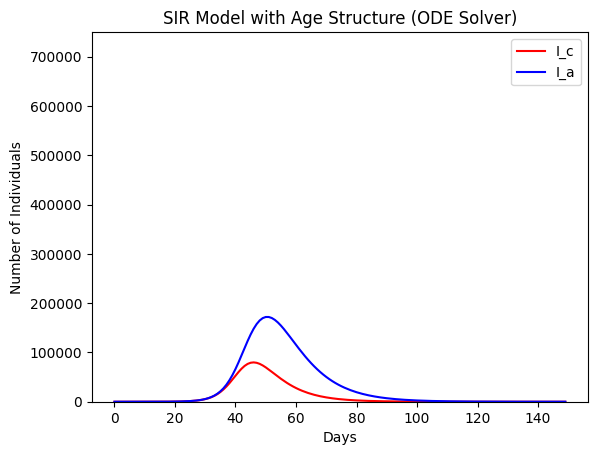

In [9]:
modelstate = initialise_modelstate(compartments, seeds, N_c, N_a)
results = ode_solver(modelstate, end_t, params, [N_c, N_a])

plot_ODE_age(results, "SIR Model with Age Structure (ODE Solver)", max(N_c, N_a))

##### **Stochastic simulation results**

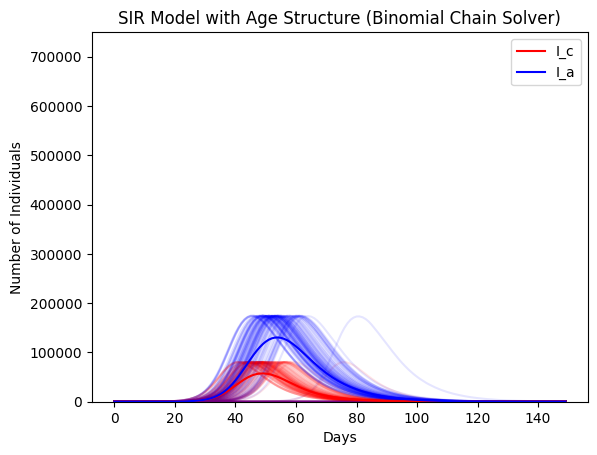

In [10]:
modelstate = initialise_modelstate(compartments, seeds, N_c, N_a)
results = binom_solver(modelstate, end_t, params, [N_c, N_a], 100)

plot_binom_age(results, "SIR Model with Age Structure (Binomial Chain Solver)", max(N_c, N_a))

### **Working from Home**

Adjust your model so that individuals are working from home by using the contact matrix you created before. Do a deterministic simulation. Did working from home affect the number of infections?

In [11]:
# SOLUTION: Perform a deterministic simulation with the working from home scenario.
# We modify the force of infection to use the working-from-home contact matrix.

def foi(I: list, params: dict, Ns: list, ac_idx: int, acs: int) -> float:
    """
    Computes the force of infection using the working-from-home contact pattern.

    Arguments
    ---------
    I     :  A list of infected individuals per age group.
    params:  A dictionary containing model parameters (expects key 'beta').
    Ns    :  A list of population sizes per age group.
    ac_idx:  The index of the current age class.
    acs   :  The total number of age classes.

    Returns
    -------
    The force of infection for the specified age group under the working-from-home scenario.

    """
    foi_value = 0

    # We use the contacts_working_from_home function here.
    for ac_j in range(acs):
        foi_value += contacts_working_from_home(ac_idx, ac_j) * I[ac_j] * params["beta"] / Ns[ac_j]

    return foi_value

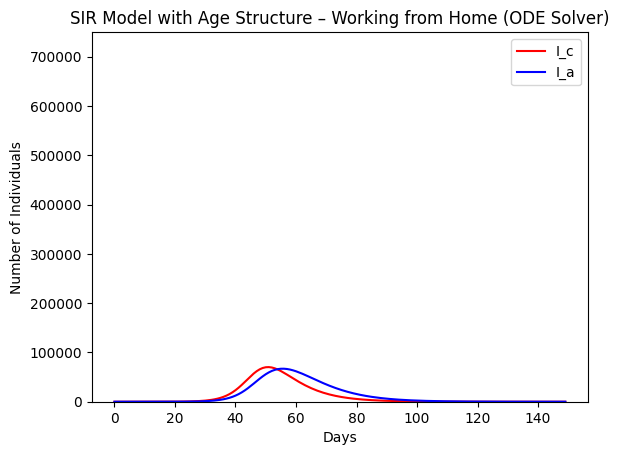

In [12]:
# Initialise the model state and perform the simulation.
modelstate = initialise_modelstate(compartments, seeds, N_c, N_a)
results = ode_solver(modelstate, end_t, params, [N_c, N_a])

# Plot the results.
plot_ODE_age(results, "SIR Model with Age Structure – Working from Home (ODE Solver)", max(N_c, N_a))